# Principal Component Analysis (PCA) on Employee_data

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD).
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" />

First of all, let's load the libraries that we'll use

In [1]:
#%pylab inline

import sys
import pandas as pd, numpy as np             # Data manipulation
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_columns', None)

The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [2]:
# un-comment when running from google cloud #

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install openpyxl

dataset_limit = 10000
keep_dates = False

# load the data file within a Pandas dataframe (change the dataset name for a different project)

# un-comment when running from google cloud #
df = pd.read_excel('/content/drive/Shared drives/Team 2.0/Machine Learning II/Benefit_factor.xlsx')

# comment when running from google cloud #

df.head()

,ben01,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,ben12,ben13,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
0,4.0,1,1.0,4,7,1.0,1.0,4.0,7,7.0,7.0,7,7.0,6,7,1.0,7.0,4.0,6,7.0,7,4,1
1,1.0,6,1.0,6,6,1.0,1.0,6.0,1,1.0,6.0,6,1.0,1,6,4.0,6.0,6.0,4,6.0,2,4,4
2,6.0,4,7.0,7,7,7.0,7.0,2.0,4,7.0,7.0,7,7.0,7,7,6.0,7.0,7.0,7,7.0,7,7,7
3,3.0,3,2.0,6,6,2.0,4.0,6.0,4,6.0,6.0,5,6.0,2,6,2.0,6.0,1.0,6,6.0,5,4,6
4,4.0,6,2.0,5,6,4.0,5.0,1.0,5,5.0,6.0,6,7.0,6,6,3.0,6.0,3.0,5,6.0,6,4,6


In [4]:
# make a copy of the original dataframe
df_orig = df.copy()

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1],
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 349
   Columns: 23 (23 num, 0 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

In [5]:
# From Luis: Checking for Nulls
null_counts = df.isnull().sum()
null_counts

,0
ben01,4
ben02,0
ben03,3
ben04,0
ben05,0
ben06,1
ben07,5
ben08,2
ben09,0
ben10,1


In [6]:
df

,ben01,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,ben12,ben13,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
0,4.0,1,1.0,4,7,1.0,1.0,4.0,7,7.0,7.0,7,7.0,6,7,1.0,7.0,4.0,6,7.0,7,4,1
1,1.0,6,1.0,6,6,1.0,1.0,6.0,1,1.0,6.0,6,1.0,1,6,4.0,6.0,6.0,4,6.0,2,4,4
2,6.0,4,7.0,7,7,7.0,7.0,2.0,4,7.0,7.0,7,7.0,7,7,6.0,7.0,7.0,7,7.0,7,7,7
3,3.0,3,2.0,6,6,2.0,4.0,6.0,4,6.0,6.0,5,6.0,2,6,2.0,6.0,1.0,6,6.0,5,4,6
4,4.0,6,2.0,5,6,4.0,5.0,1.0,5,5.0,6.0,6,7.0,6,6,3.0,6.0,3.0,5,6.0,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1.0,2,2.0,5,5,2.0,3.0,4.0,4,3.0,6.0,5,6.0,4,4,2.0,6.0,3.0,5,2.0,4,2,4
345,1.0,7,7.0,7,7,4.0,7.0,7.0,7,7.0,7.0,7,7.0,1,7,7.0,7.0,7.0,7,4.0,7,7,7
346,4.0,5,7.0,7,7,7.0,7.0,7.0,7,7.0,7.0,4,7.0,7,7,3.0,7.0,2.0,7,7.0,4,4,7
347,7.0,7,2.0,6,7,4.0,2.0,2.0,6,6.0,7.0,2,7.0,4,2,2.0,6.0,2.0,7,6.0,4,2,7


We then need to impute missing values (or drop the records)

In [7]:
# From Luis: Setting impute to FALSE since the number of nulls is very low
# OJO: The values in the Labels at the end of the nb are applicable only is this is TRUE. If False, values change

impute = False

if impute:
    # Use mean for numerical features
    for feature in numerical_columns:
        v = df[feature].mean()
        if np.isnan(v):
            v = 0
        print("Filling %s with %s" % (feature, v))
        df[feature] = df[feature].fillna(v)

    # Use mode for categorical features
    for feature in categorical_columns:
        v = df[feature].value_counts()
        df[feature] = df[feature].fillna(v)

else:
    # drop records
    df.dropna(inplace=True)


In [8]:
df.shape

(328, 23)

In [9]:
df

,ben01,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,ben12,ben13,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
0,4.0,1,1.0,4,7,1.0,1.0,4.0,7,7.0,7.0,7,7.0,6,7,1.0,7.0,4.0,6,7.0,7,4,1
1,1.0,6,1.0,6,6,1.0,1.0,6.0,1,1.0,6.0,6,1.0,1,6,4.0,6.0,6.0,4,6.0,2,4,4
2,6.0,4,7.0,7,7,7.0,7.0,2.0,4,7.0,7.0,7,7.0,7,7,6.0,7.0,7.0,7,7.0,7,7,7
3,3.0,3,2.0,6,6,2.0,4.0,6.0,4,6.0,6.0,5,6.0,2,6,2.0,6.0,1.0,6,6.0,5,4,6
4,4.0,6,2.0,5,6,4.0,5.0,1.0,5,5.0,6.0,6,7.0,6,6,3.0,6.0,3.0,5,6.0,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1.0,2,2.0,5,5,2.0,3.0,4.0,4,3.0,6.0,5,6.0,4,4,2.0,6.0,3.0,5,2.0,4,2,4
345,1.0,7,7.0,7,7,4.0,7.0,7.0,7,7.0,7.0,7,7.0,1,7,7.0,7.0,7.0,7,4.0,7,7,7
346,4.0,5,7.0,7,7,7.0,7.0,7.0,7,7.0,7.0,4,7.0,7,7,3.0,7.0,2.0,7,7.0,4,4,7
347,7.0,7,2.0,6,7,4.0,2.0,2.0,6,6.0,7.0,2,7.0,4,2,2.0,6.0,2.0,7,6.0,4,2,7


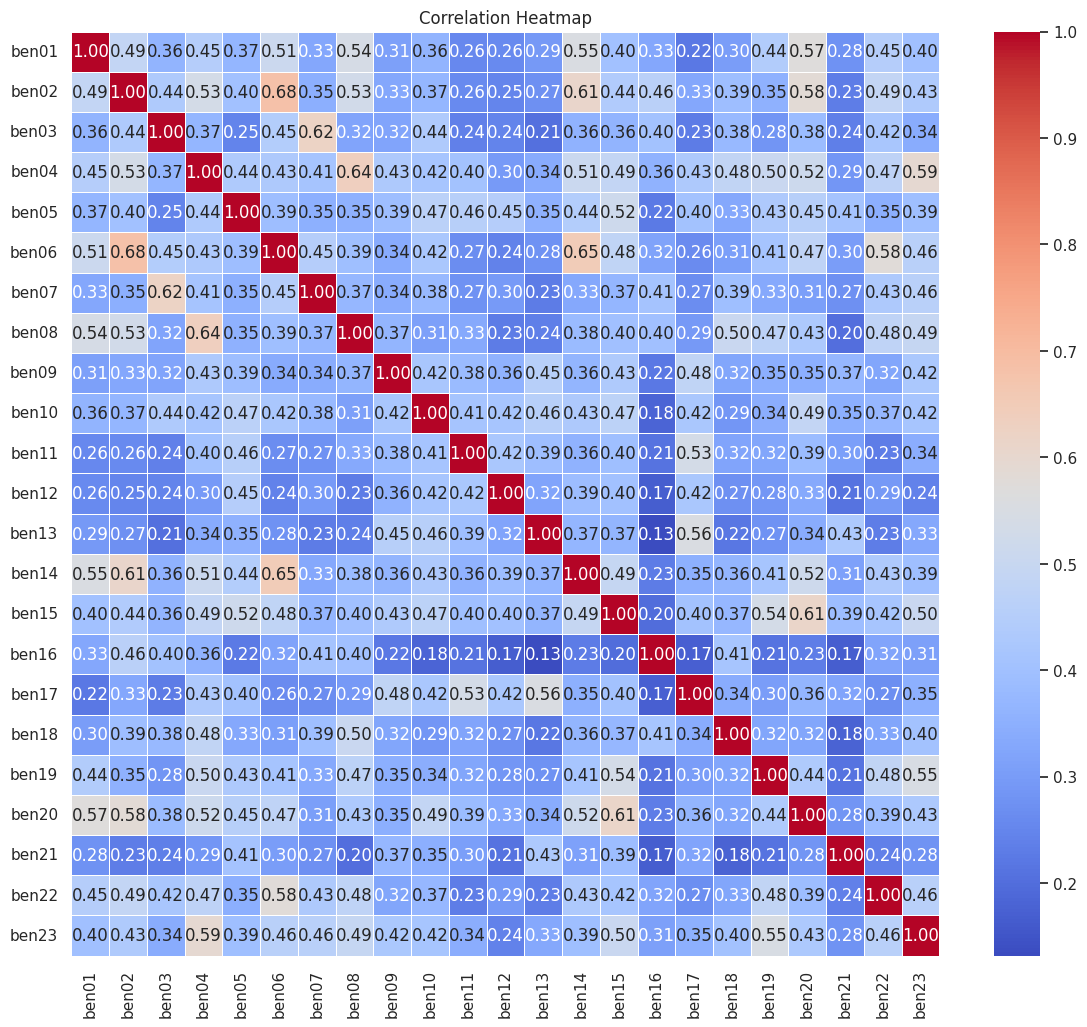

In [10]:
# Heatmap to show correlation between explanatory variables
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))  # You can adjust the figure size
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Finally, we rescale the whole data

In [11]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(df)
X_std = ss.transform(df)
X_std

array([[-0.19544402, -1.88111461, -1.44812595, ...,  0.70996447,
        -0.57504759, -2.8184462 ],
       [-1.57901894,  0.51595451, -1.44812595, ..., -2.45400762,
        -0.57504759, -0.98300539],
       [ 0.72693926, -0.44287314,  1.35414728, ...,  0.70996447,
         0.99674916,  0.85243542],
       ...,
       [-0.19544402,  0.03654069,  1.35414728, ..., -1.18841879,
        -0.57504759,  0.85243542],
       [ 1.1881309 ,  0.99536834, -0.98108041, ..., -1.18841879,
        -1.62291209,  0.85243542],
       [ 1.1881309 ,  0.99536834,  0.4200562 , ...,  0.70996447,
         0.99674916,  0.85243542]])

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)

In [12]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)
Y_sklearn

array([[-1.39187596,  3.96714065, -1.34277405, ..., -0.42366313,
        -0.88095434, -0.44919122],
       [-4.36892841, -2.09736402,  0.21705256, ...,  0.59141657,
        -0.01920544,  0.20213286],
       [ 2.90912804,  0.02552203,  0.37532057, ...,  0.10613258,
         0.65267473, -0.20162702],
       ...,
       [ 2.06217688,  0.02436992, -0.48384822, ...,  0.64426401,
        -0.25925345, -0.96955288],
       [-1.52965586,  0.45898904, -1.71520173, ..., -0.39468232,
         0.3323566 ,  1.14705635],
       [ 3.55215981,  0.20055762, -0.89676427, ...,  0.10985586,
        -0.10492908,  0.08929056]])

Here the PCA is a full SVD (k=d, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

We also compute how many of these vectors (in order) must be used to retain 90% of the variance of the original dataset (you can change that figure below)

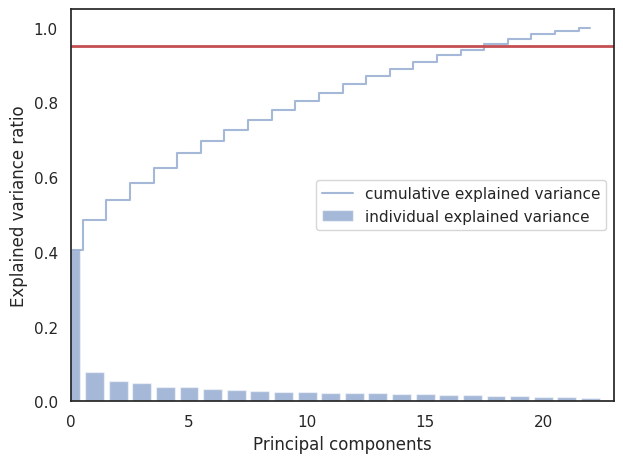

In [13]:
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()


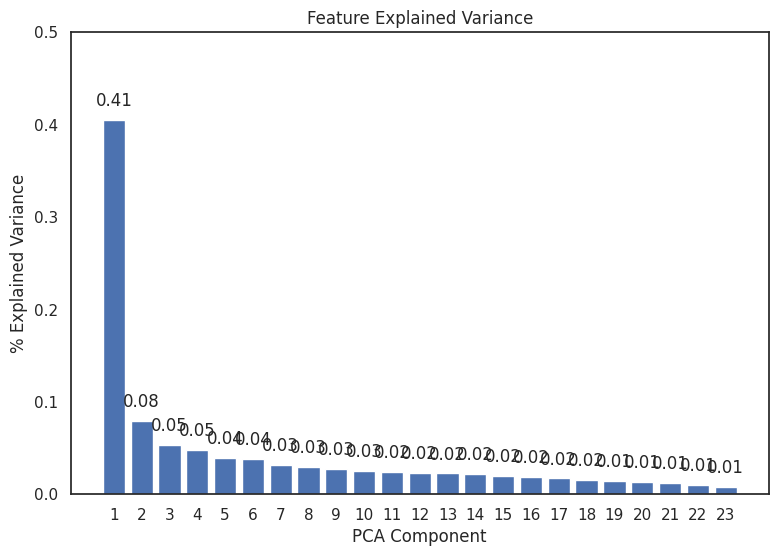

In [14]:
#Bar plot of explained_variance
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
ax.bar(
    x      = np.arange(sklearn_pca.n_components_) + 1,
    height = sklearn_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, sklearn_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(sklearn_pca.n_components_) + 1)
ax.set_ylim(0, 0.5)
ax.set_title('Feature Explained Variance')
ax.set_xlabel('PCA Component')
ax.set_ylabel('% Explained Variance');

In [15]:
# Show data from the chart
print ("Component explained variance:")
variances = pd.DataFrame(sklearn_pca.explained_variance_ratio_, columns=['Variances'])
variances_cum = pd.DataFrame(sklearn_pca.explained_variance_ratio_.cumsum(), columns=['Cumulative'])
frames = [variances, variances_cum]
df_var = pd.concat(frames, sort=False, axis=1)
df_var

Component explained variance:


,Variances,Cumulative
0,0.405214,0.405214
1,0.079443,0.484658
2,0.053096,0.537754
3,0.047783,0.585537
4,0.039468,0.625006
5,0.038662,0.663668
6,0.032059,0.695728
7,0.029695,0.725423
8,0.027707,0.753129
9,0.025633,0.778762


In [16]:
## ADDED THIS TO SEE THE RATIOS - there's so many values in the dataset that we can't see the ratios

# Display the eigenvalues and their ratios
eigenvalues = sklearn_pca.explained_variance_
eigenvalues_ratio = eigenvalues / eigenvalues.sum()
cumulative_ratio = eigenvalues_ratio.cumsum()

eigenvalues_df = pd.DataFrame({
    'Eigenvalues': eigenvalues,
    'Eigenvalues Ratio': eigenvalues_ratio,
    'Cumulative Ratio': cumulative_ratio
})

## We can use this to justify which factors to keep and add a filter to only show the ones above 1
eigenvalues_df = eigenvalues_df[eigenvalues_df['Eigenvalues'] > 1]

print(eigenvalues_df)

   Eigenvalues  Eigenvalues Ratio  Cumulative Ratio
0     9.348433           0.405214          0.405214
1     1.832785           0.079443          0.484658
2     1.224953           0.053096          0.537754
3     1.102374           0.047783          0.585537


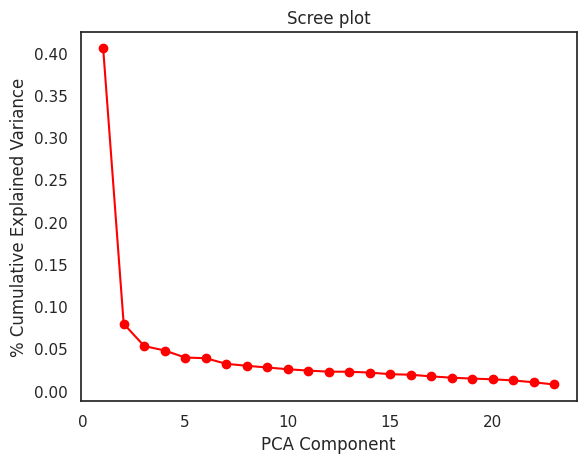

In [17]:
# Scree plot - Explained Variance
plt.plot(
    range(1,len(sklearn_pca.explained_variance_ratio_ )+1),
    sklearn_pca.explained_variance_ratio_,
    c='red', marker='o'
)

plt.xlabel('PCA Component')
plt.ylabel('% Cumulative Explained Variance')
plt.title('Scree plot')
plt.show()

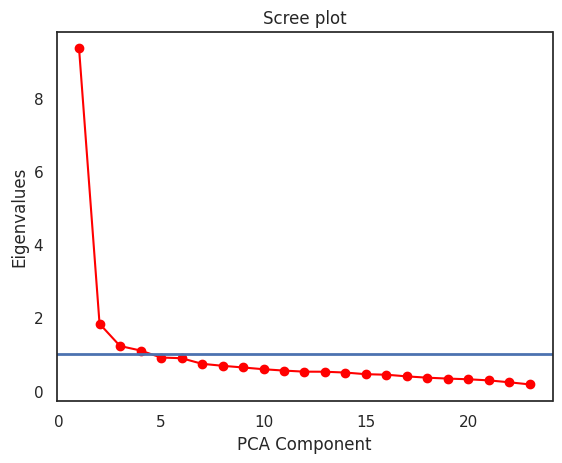

In [18]:
# Scree plot - Eigen Values
plt.plot(
    range(1,len(sklearn_pca.explained_variance_)+1),
    sklearn_pca.explained_variance_,
    c='red', marker='o'
)

plt.xlabel('PCA Component')
plt.ylabel('Eigenvalues')
plt.title('Scree plot')
plt.axhline(y=1, linewidth=2, color = 'b')
plt.show()

## Retaining only some vectors <a id="final-pca" />

You should decide now how many components you want to keep and change the following parameter.

By default we keep the recommended value from the above figure

In [19]:
## CHANGED THE VARIANCE_TO_KEEP to the cummulative of the 4 first factors

VARIANCE_TO_KEEP = 0.60
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

Number of components to keep to retain 60.0% of the variance: 4 out of the original 23


Let's run the PCA again but with a limited number of components this time

In [20]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

In [21]:
# Shows loading factors = correlations between variables and factors
print ("Loading factors:")

dfloading=pd.DataFrame(
    data    = sklearn_pca_final.components_,
    columns = df.columns,
)

index_list=[]
for n in range(retained_components_number):
    index_list.append("PC"+str(n+1))

dfloading.index = index_list
dfloading

Loading factors:


,ben01,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,ben12,ben13,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
PC1,0.215364,0.233066,0.192899,0.245521,0.216119,0.230575,0.199751,0.219561,0.202119,0.215841,0.188145,0.171622,0.177654,0.233648,0.237125,0.154777,0.192755,0.190940,0.210969,0.233061,0.158273,0.214507,0.227372
PC2,-0.174300,-0.236763,-0.202677,-0.075088,0.190198,-0.202183,-0.157131,-0.210833,0.211302,0.185157,0.301141,0.262666,0.364562,-0.032968,0.101406,-0.294119,0.360245,-0.120641,-0.047346,-0.005442,0.239778,-0.206364,-0.067664
PC3,-0.271547,-0.164068,0.281438,0.050620,-0.073131,-0.250187,0.369705,0.069115,0.151828,-0.012629,0.152110,0.072716,0.014947,-0.305596,-0.171303,0.401715,0.167368,0.354422,-0.159700,-0.290625,-0.011094,-0.075433,0.052902
PC4,-0.009757,0.075758,0.428240,-0.310608,-0.016632,0.273729,0.293582,-0.391958,-0.015206,0.237826,-0.143718,0.062319,0.085290,0.129176,-0.032670,0.039304,-0.107131,-0.239898,-0.305893,-0.010425,0.276324,0.050416,-0.223080


Each variable can be expressed as a lineal combination of Factors. For instance:
educ = 0.452923*PC1 -0.125929*PC2 -0.042881*PC3


Now we hide values lower than 0.2 or 0.3 to display better the relations

In [22]:
# Hide values so that it is clearer
dfloading2 = dfloading.where(abs(dfloading) > 0.25  , "")
dfloading2

,ben01,ben02,ben03,ben04,ben05,ben06,ben07,ben08,ben09,ben10,ben11,ben12,ben13,ben14,ben15,ben16,ben17,ben18,ben19,ben20,ben21,ben22,ben23
PC1,,,,,,,,,,,,,,,,,,,,,,,
PC2,,,,,,,,,,,0.301141,0.262666,0.364562,,,-0.294119,0.360245,,,,,,
PC3,-0.271547,,0.281438,,,-0.250187,0.369705,,,,,,,-0.305596,,0.401715,,0.354422,,-0.290625,,,
PC4,,,0.42824,-0.310608,,0.273729,0.293582,-0.391958,,,,,,,,,,,-0.305893,,0.276324,,


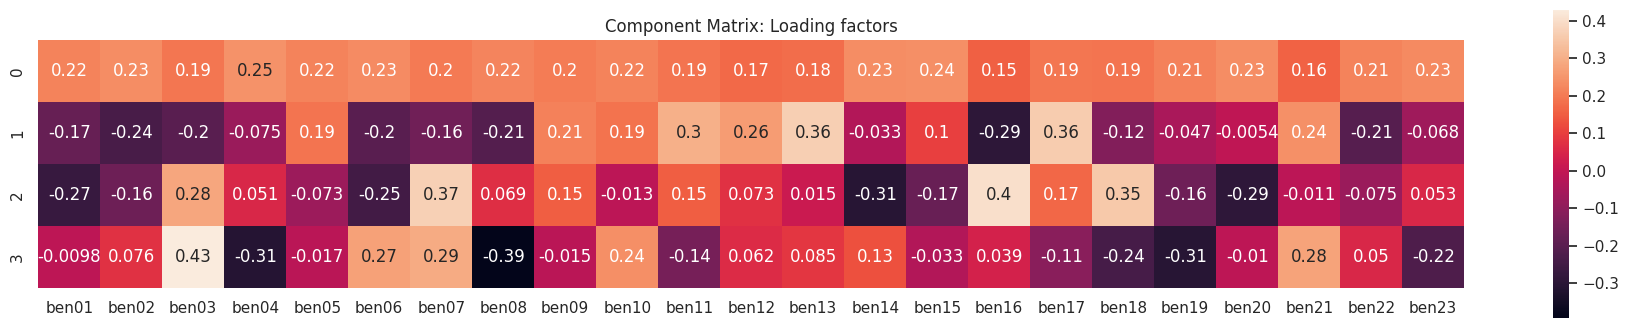

In [23]:
# For display reasons, we don't show all components if more than 50 (same for input variables)
n_components_to_show = min(50, sklearn_pca_final.n_components_)
n_input_features = sklearn_pca_final.components_.shape[1]

decomp_df = pd.DataFrame(sklearn_pca_final.components_[0:n_components_to_show],
                            columns=df.columns)
if decomp_df.shape[1] > 50:
    decomp_df = decomp_df[decomp_df.columns[0:50]]

fig = plt.figure(figsize=(n_input_features, n_components_to_show))
sns.set(font_scale=1)
sns.heatmap(decomp_df, square=True, annot=True).set(title='Component Matrix: Loading factors')
sns.set(font_scale=1)

### Communalities
In order to calculate communalities (% of information explained from each variable), we need to square the loading factors of each variable.

In [24]:
# Communalities
commun=[]

for col in dfloading.columns:
    commun.append((dfloading.iloc[0:3][col]**2).sum())

dfcommun = pd.DataFrame(commun,index=dfloading.columns, columns=["Communalities"])
dfcommun.sort_values("Communalities", ascending=False)

,Communalities
ben16,0.271837
ben07,0.201272
ben17,0.194943
ben18,0.176627
ben13,0.164690
ben03,0.157496
ben06,0.156637
ben01,0.150500
ben11,0.149222
ben14,0.149067


<ipython-input-25-25966dc3152e>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[idx].text(xs[i], ys[i], " " + varname)
<ipython-input-25-25966dc3152e>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[idx].text(xs[i], ys[i], " " + varname)
<ipython-input-25-25966dc3152e>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[idx].text(xs[i], ys[i], " " + varname)
<ipython-input-25-25966dc3152e>:23: FutureWarning: Series.

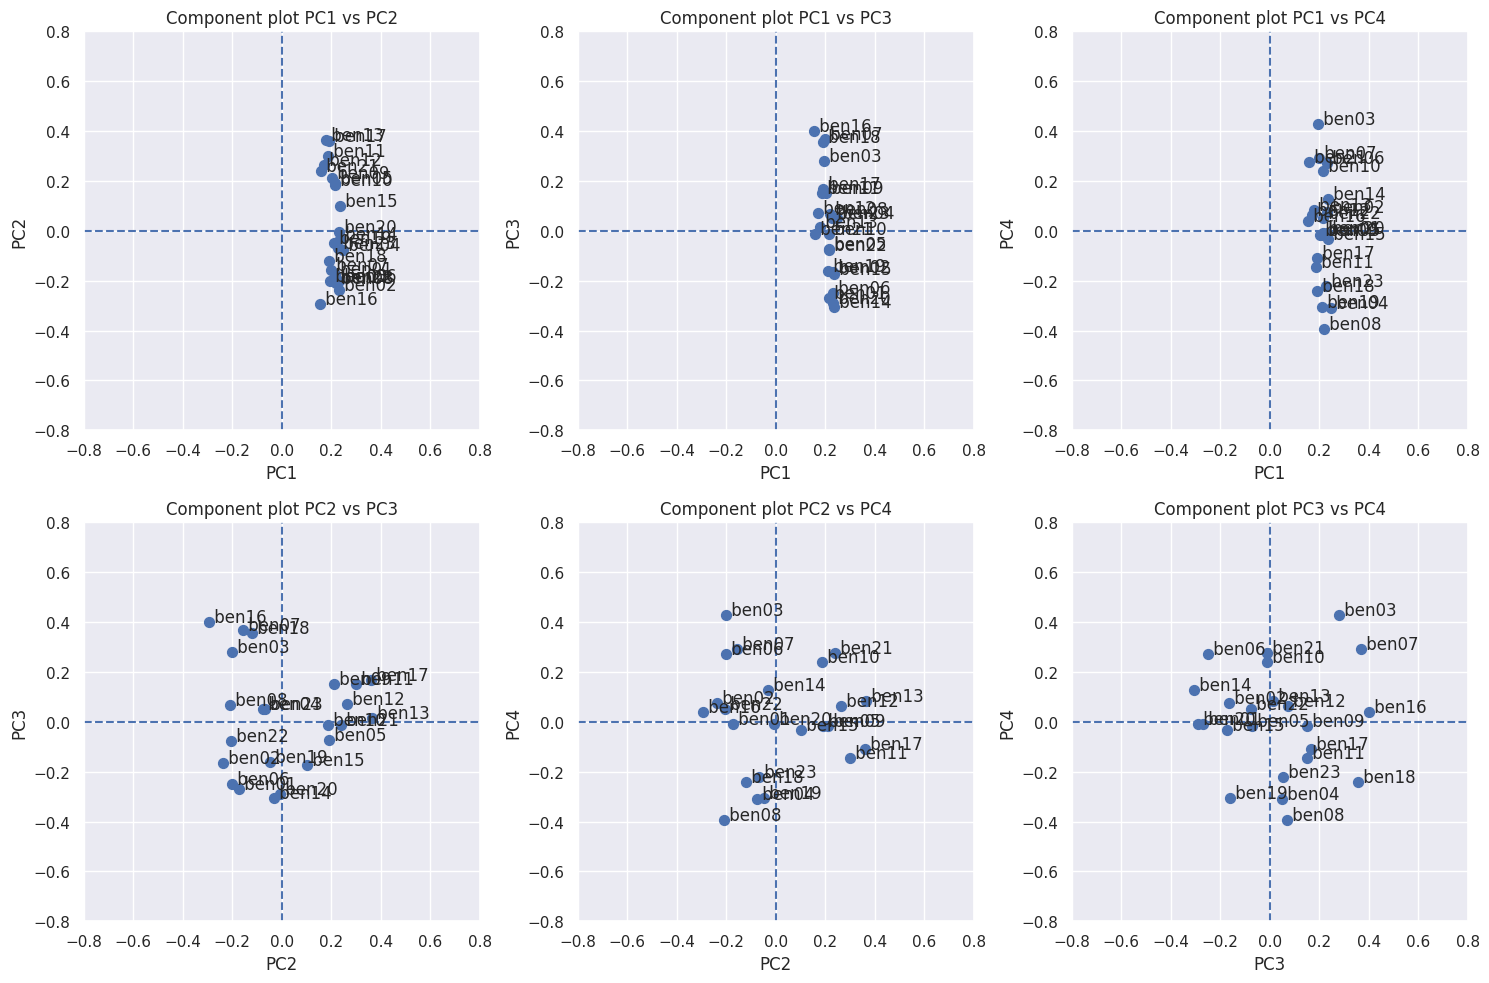

In [25]:
## NOT SURE WE SHOULD ADD THIS - there's 4 factors so we can't represent them in a 2D plot
#Create all possible combinations of PCs
pc_combinations = [
    (1,2), (1,3), (1,4),
    (2,3), (2,4),
    (3,4)
]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (pc_x, pc_y) in enumerate(pc_combinations):
    # Get the loadings for the current pair of PCs
    xs = dfloading.T[f'PC{pc_x}']
    ys = dfloading.T[f'PC{pc_y}']

    axes[idx].axhline(y=0, color='b', linestyle='dashed')
    axes[idx].axvline(x=0, color='b', linestyle='dashed')

    axes[idx].scatter(xs, ys, s=50)
    for i, varname in enumerate(dfloading.columns):
        axes[idx].text(xs[i], ys[i], " " + varname)

    axes[idx].set_xlabel(f'PC{pc_x}')
    axes[idx].set_ylabel(f'PC{pc_y}')
    axes[idx].set_title(f'Component plot PC{pc_x} vs PC{pc_y}')

    axes[idx].set_xlim(-0.8, 0.8)
    axes[idx].set_ylim(-0.8, 0.8)

plt.tight_layout()
plt.show()

<ipython-input-26-8fd196463c41>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(xs[i], ys[i], zs[i], varname)


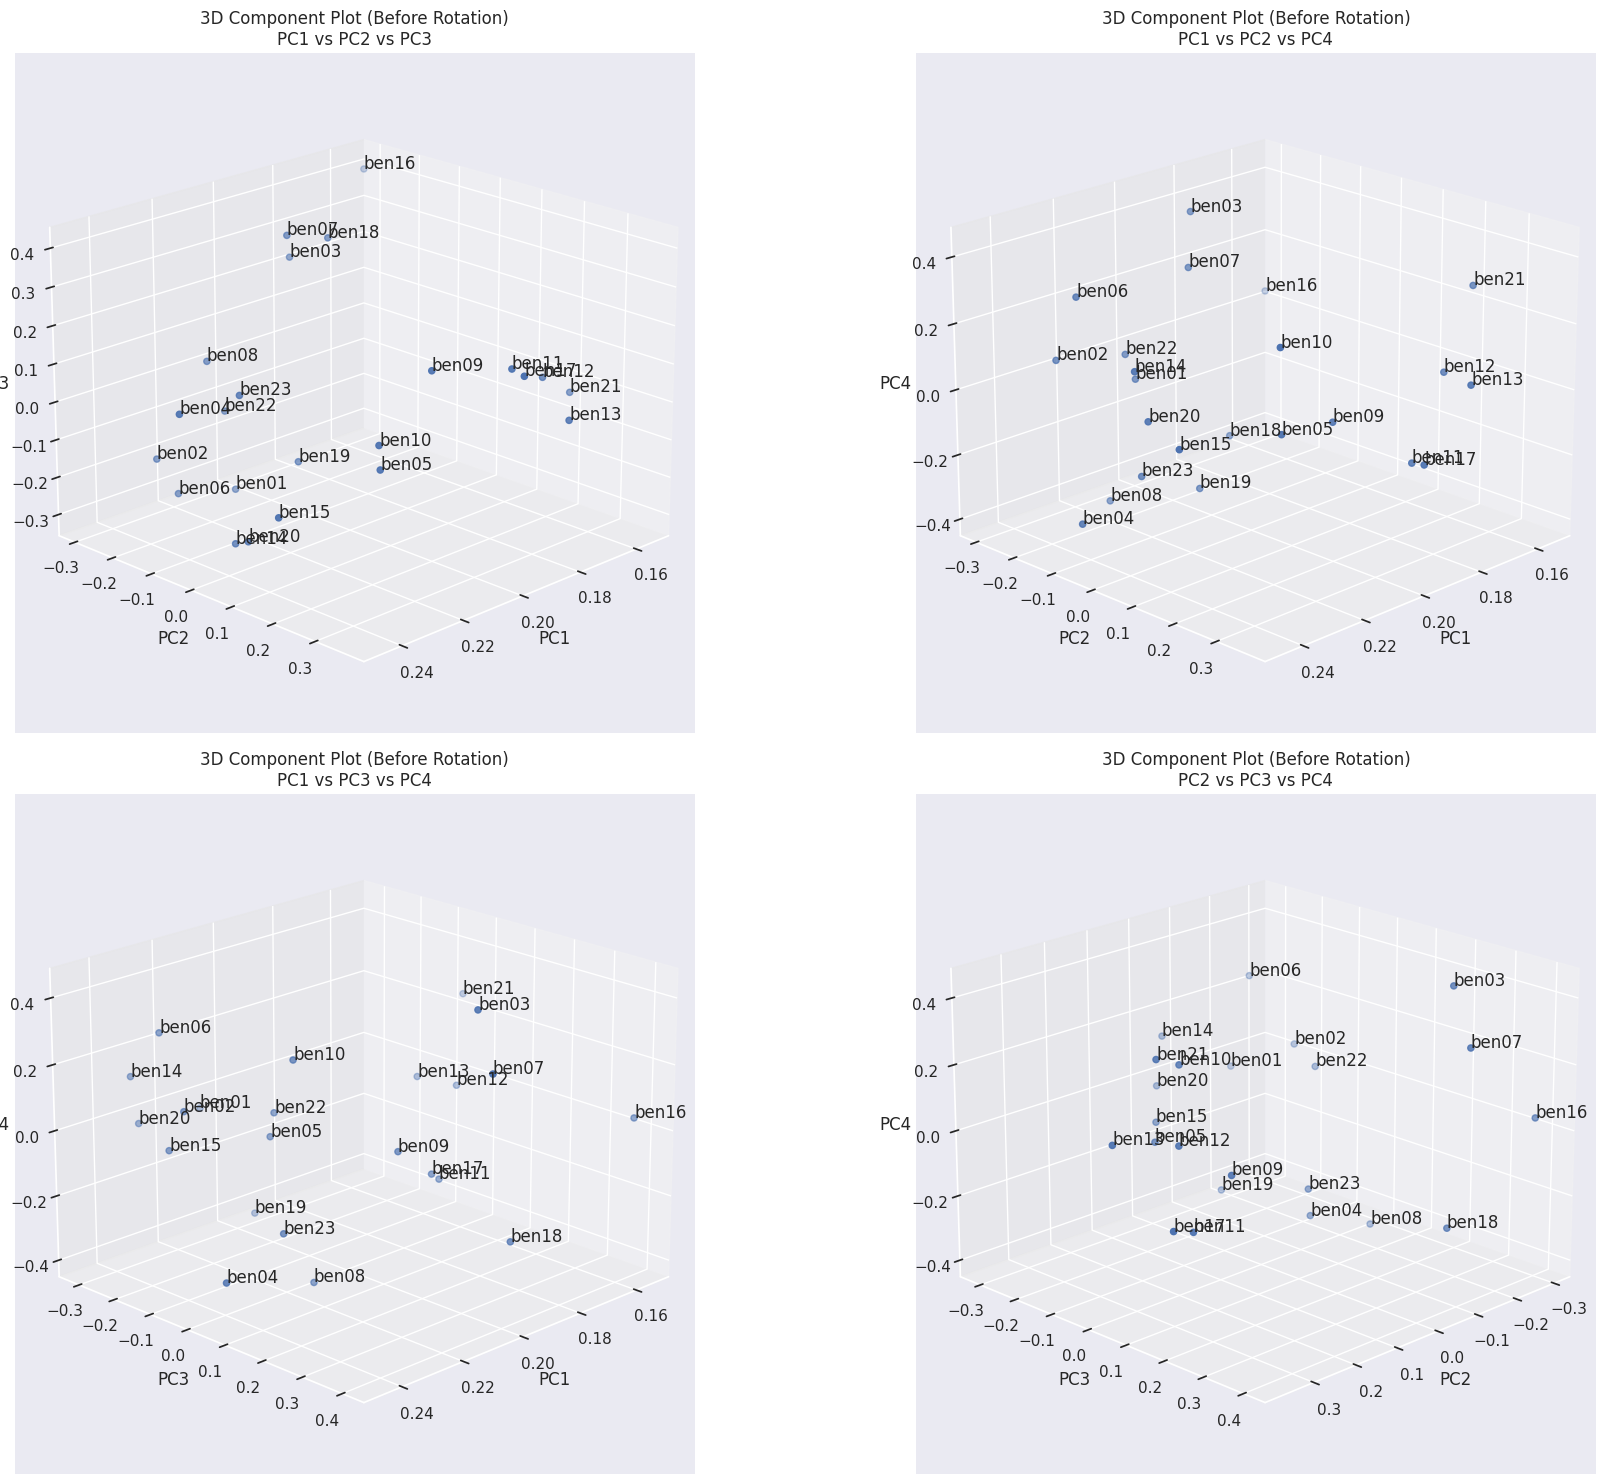

In [26]:
#CREATED A 3D PLOT JUST TO SEE A DIFFERENT TYPE OF VISUALIZATION.
from mpl_toolkits.mplot3d import Axes3D

# combinations for 3D plots
pc_combinations_3d = [
    ('PC1', 'PC2', 'PC3'),
    ('PC1', 'PC2', 'PC4'),
    ('PC1', 'PC3', 'PC4'),
    ('PC2', 'PC3', 'PC4')
]

# subplots for all 3D combinations
fig = plt.figure(figsize=(20, 15))

for idx, (pc_x, pc_y, pc_z) in enumerate(pc_combinations_3d, 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')

    xs = dfloading.loc[pc_x]
    ys = dfloading.loc[pc_y]
    zs = dfloading.loc[pc_z]

    ax.scatter(xs, ys, zs)

    for i, varname in enumerate(dfloading.columns):
        ax.text(xs[i], ys[i], zs[i], varname)

    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_zlabel(pc_z)
    ax.set_title(f'3D Component Plot (Before Rotation)\n{pc_x} vs {pc_y} vs {pc_z}')

    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('3D Component plots before rotation.png')
plt.show()
plt.show()

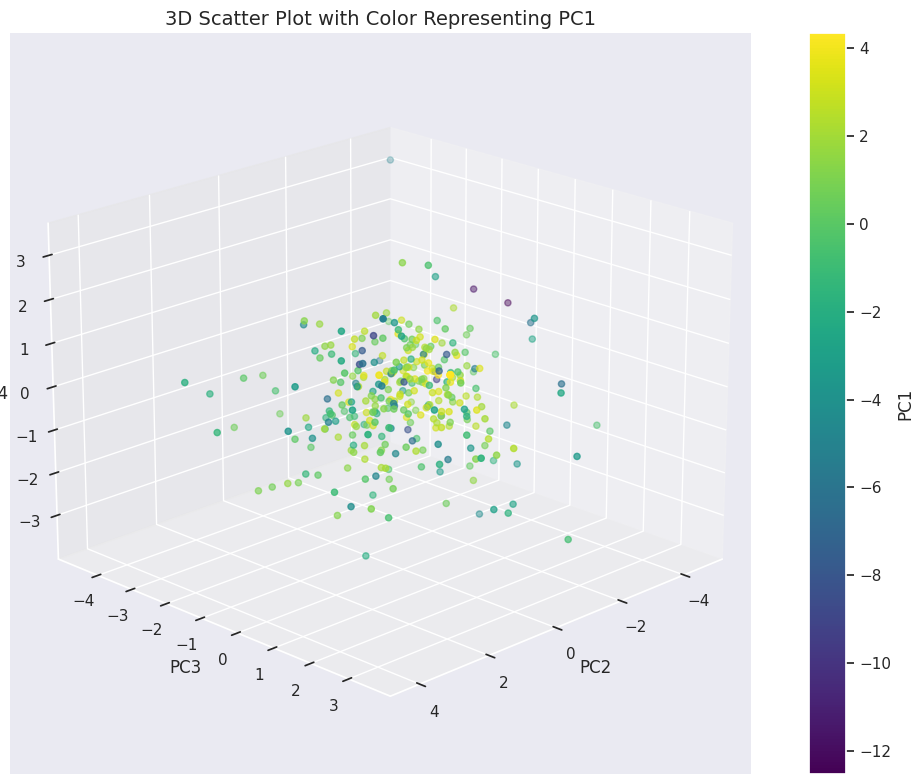

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a single 3D scatter plot with PC1 as color
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract principal components
xs = pca_df_4['PC2']  # x-axis
ys = pca_df_4['PC3']  # y-axis
zs = pca_df_4['PC4']  # z-axis
color_dimension = pca_df_4['PC1']  # color

# Create scatter plot
sc = ax.scatter(xs, ys, zs,
                c=color_dimension,
                cmap='viridis',
                marker='o')

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label('PC1', fontsize=12)

# Set labels and title
ax.set_xlabel('PC2', fontsize=12)
ax.set_ylabel('PC3', fontsize=12)
ax.set_zlabel('PC4', fontsize=12)
ax.set_title('3D Scatter Plot with Color Representing PC1', fontsize=14)

# Set the viewing angle for better visualization
ax.view_init(elev=20, azim=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

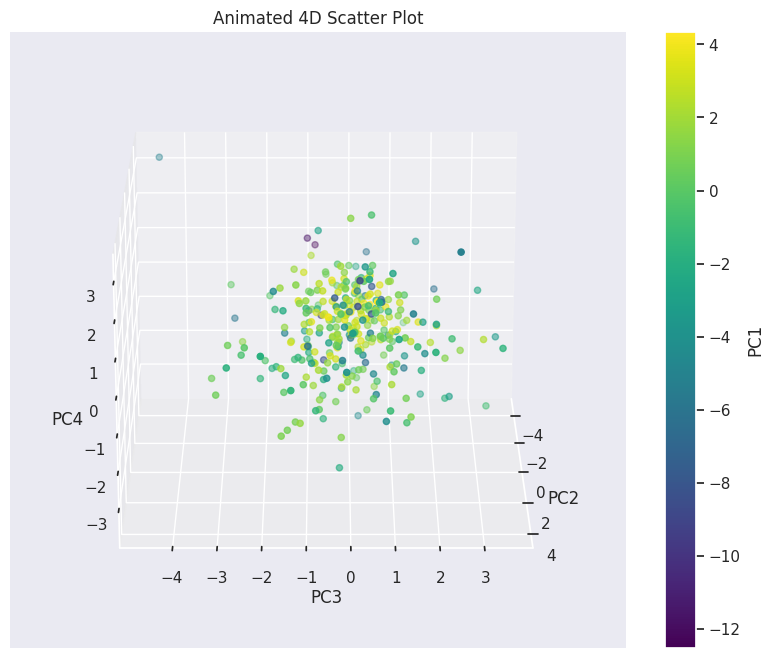

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


# Create figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract principal components
xs = pca_df_4['PC2']
ys = pca_df_4['PC3']
zs = pca_df_4['PC4']
colors = pca_df_4['PC1']

# Create scatter plot
scatter = ax.scatter(xs, ys, zs, c=colors, cmap='viridis')

# Add colorbar
plt.colorbar(scatter, label='PC1')

# Set labels
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_zlabel('PC4')
ax.set_title('Animated 4D Scatter Plot')

# Animation function
def rotate(frame):
    ax.view_init(elev=20, azim=frame)
    return fig,

# Create animation
anim = animation.FuncAnimation(fig, rotate, frames=np.linspace(0, 360, 180),
                             interval=50, blit=True)

# Save animation (optional)
anim.save('rotation.gif', writer='pillow')

plt.show()

### Visualizing projected vectors

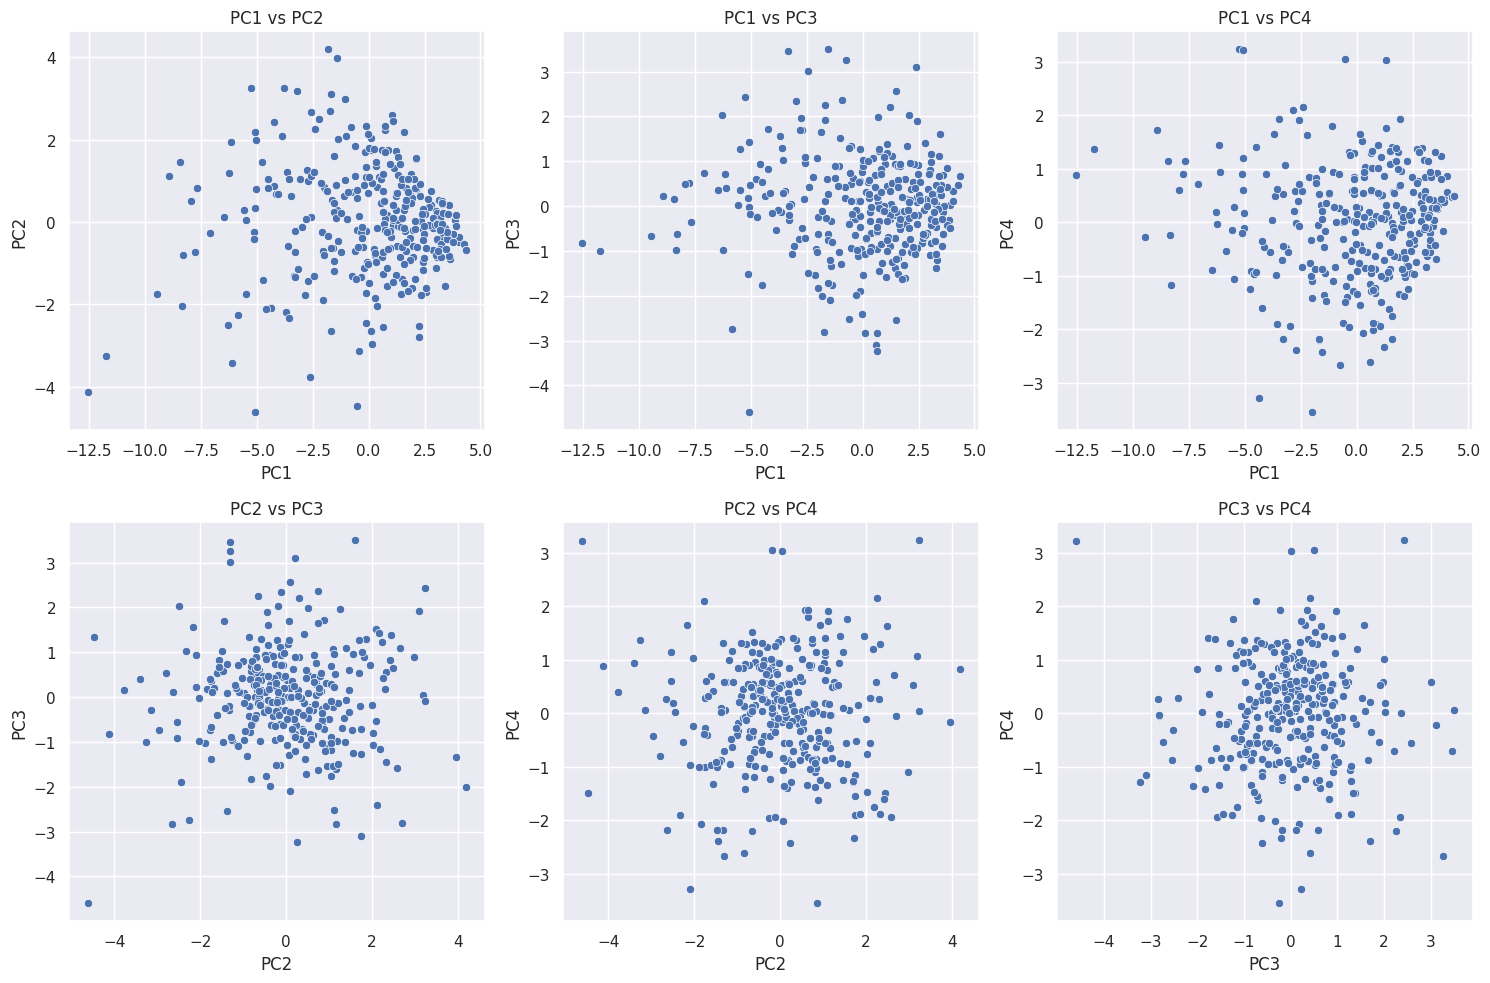

In [27]:
# PCA with 4 components
sklearn_pca_4 = PCA(n_components=4)
Y_sklearn_4 = sklearn_pca_4.fit_transform(X_std)

# dataFrame with all 4 PCs
pca_df_4 = pd.DataFrame(
    data=Y_sklearn_4,
    columns=['PC1', 'PC2', 'PC3', 'PC4']
)

# subplots for all combinations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# plot combinations
pc_combinations = [
    (0,1), (0,2), (0,3),
    (1,2), (1,3),
    (2,3)
]

for idx, (pc_x, pc_y) in enumerate(pc_combinations):
    sns.scatterplot(
        data=pca_df_4,
        x=f'PC{pc_x+1}',
        y=f'PC{pc_y+1}',
        ax=axes[idx]
    )
    axes[idx].set_title(f'PC{pc_x+1} vs PC{pc_y+1}')

plt.tight_layout()
plt.show()

In [28]:
sklearn_pca_4 = PCA(n_components=4)
Y_sklearn_4 = sklearn_pca_4.fit_transform(X_std)
indx=np.arange(1, Y_sklearn_4.shape[0]+1)

pca_df_4 = pd.DataFrame(
    data=Y_sklearn_4,
    columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [29]:
# and now it shows the data projections
pca_df_4

,PC1,PC2,PC3,PC4
0,-1.391876,3.967141,-1.342774,-0.155262
1,-4.368928,-2.097364,0.217053,-3.271807
2,2.909128,0.025522,0.375321,1.383015
3,-2.007860,0.814664,-0.614272,-1.090981
4,-1.074562,1.019884,-1.015263,0.939331
...,...,...,...,...
323,-4.513637,0.820474,0.543670,-0.935181
324,2.375576,0.203125,3.108738,-0.218038
325,2.062177,0.024370,-0.483848,0.249151
326,-1.529656,0.458989,-1.715202,-0.873797


In [30]:
# Combine original data with components created
frames = [df_orig.reset_index(drop=True), pca_df_4.reset_index(drop=True)]
dffinal = pd.concat(frames, axis=1)
dffinal.to_excel("Final.xlsx")

## Rotations

In [31]:
from sklearn.decomposition import PCA, FactorAnalysis

n_comps = 4
methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]

num_methods = np.arange(3)
for ax, (method, fa) in zip(num_methods, methods):
    fa.set_params(n_components=n_comps)
    ss = StandardScaler().fit(df)
    X_std = ss.transform(df)
    Y_sklearn = fa.fit_transform(X_std)
    components = fa.components_.T

    if method == "Unrotated FA":
        df_factor = pd.DataFrame(
            components,
            columns=['PC1', 'PC2', 'PC3', 'PC4'],
            index=df.columns
        )
    elif method == "Varimax FA":
        df_varimax = pd.DataFrame(
            components,
            columns=['PC1', 'PC2', 'PC3', 'PC4'],
            index=df.columns
        )
    else:
        df_pca = pd.DataFrame(
            components,
            columns=['PC1', 'PC2', 'PC3', 'PC4'],
            index=df.columns
        )


In [32]:
print("PCA: ")
df_pca.where(abs(df_pca) > 0.3  , "")

PCA: 


,PC1,PC2,PC3,PC4
ben01,,,,
ben02,,,,
ben03,,,,0.42824
ben04,,,,-0.310608
ben05,,,,
ben06,,,,
ben07,,,0.369705,
ben08,,,,-0.391958
ben09,,,,
ben10,,,,


In [33]:
print("Unrotated Factor: ")
df_factor.where(abs(df_factor) > 0.3  , "")

Unrotated Factor: 


,PC1,PC2,PC3,PC4
ben01,-0.649501,,,
ben02,-0.728089,,,
ben03,-0.589152,,,0.38816
ben04,-0.741711,,,
ben05,-0.619316,,,
ben06,-0.724228,,0.304623,
ben07,-0.607840,,-0.363393,0.362128
ben08,-0.674364,,,-0.401006
ben09,-0.576734,,,
ben10,-0.624808,,,


In [34]:
print("Varimax rotation: ")
df_varimax.where(abs(df_varimax) > 0.3  , "")

Varimax rotation: 


,PC1,PC2,PC3,PC4
ben01,-0.542404,,-0.376798,
ben02,-0.687659,,-0.35707,
ben03,-0.314628,,,0.678913
ben04,-0.331201,-0.32653,-0.625623,
ben05,-0.329717,-0.51873,,
ben06,-0.772509,,,
ben07,,,,0.727055
ben08,,,-0.749798,
ben09,,-0.520526,,
ben10,-0.335204,-0.526691,,


<ipython-input-35-d98c4f24224e>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[idx].scatter(xs[i], ys[i], s=50)
<ipython-input-35-d98c4f24224e>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[idx].text(xs[i], ys[i], " " + varnames)


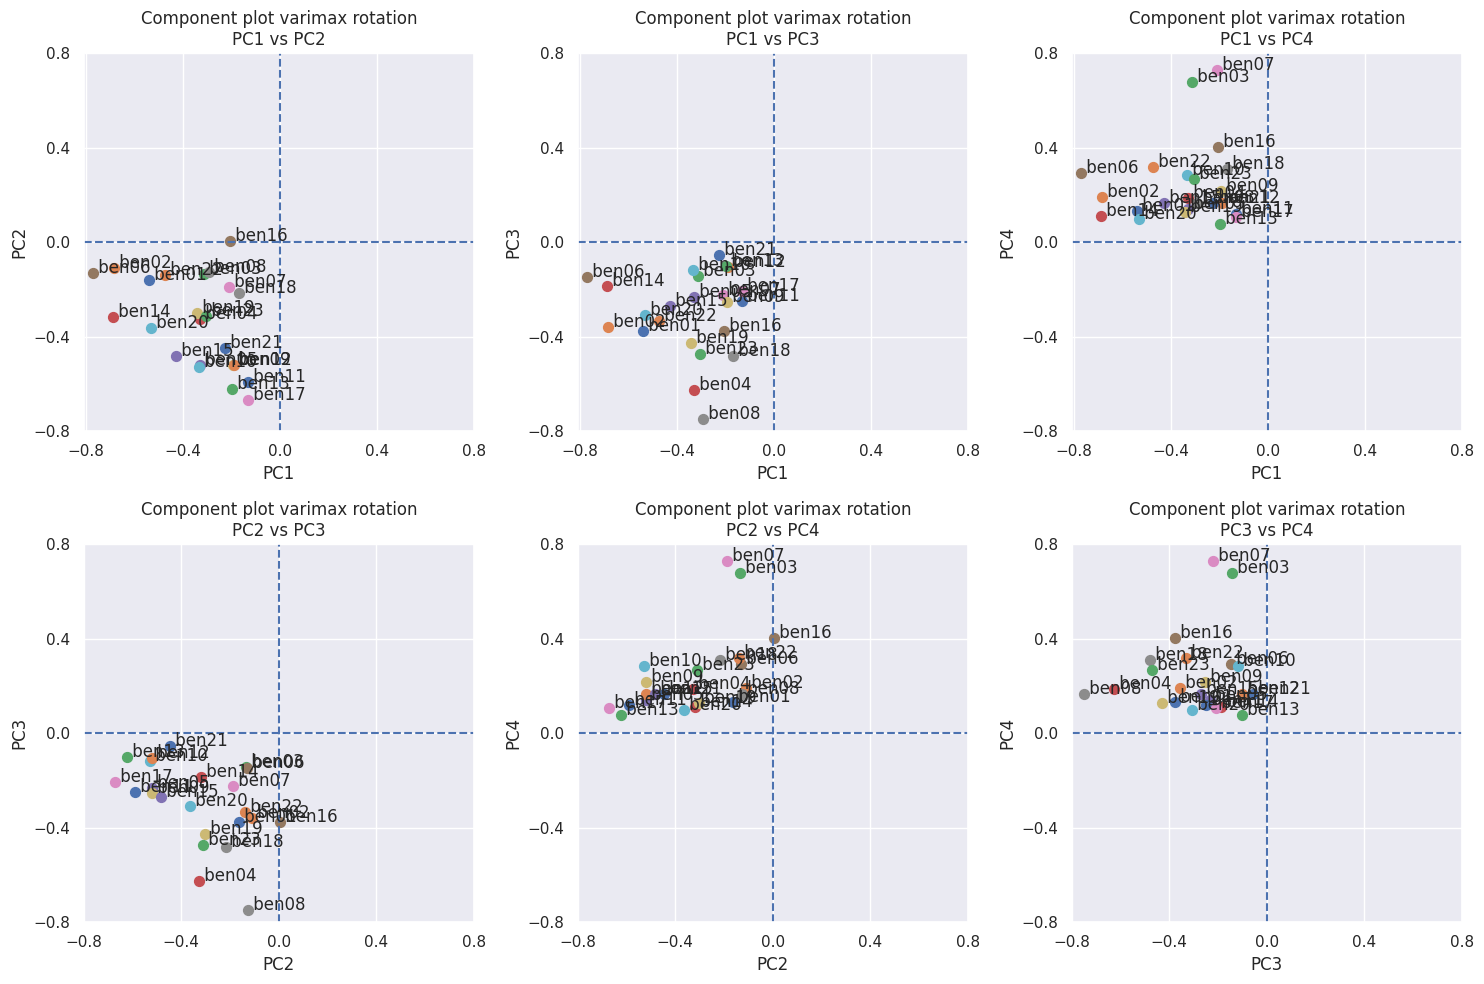

In [35]:
# subplots for all combinations of components
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

#  all combinations of PCs
pc_combinations = [
    ('PC1', 'PC2'),
    ('PC1', 'PC3'),
    ('PC1', 'PC4'),
    ('PC2', 'PC3'),
    ('PC2', 'PC4'),
    ('PC3', 'PC4')
]

for idx, (pc_x, pc_y) in enumerate(pc_combinations):
    xs = df_varimax[pc_x]
    ys = df_varimax[pc_y]

    axes[idx].axvline(x=0, color='b', linestyle='dashed')
    axes[idx].axhline(y=0, color='b', linestyle='dashed')

    for i, varnames in enumerate(df_varimax.index):
        axes[idx].scatter(xs[i], ys[i], s=50)
        axes[idx].text(xs[i], ys[i], " " + varnames)

    xticks = np.linspace(-0.8, 0.8, num=5)
    yticks = np.linspace(-0.8, 0.8, num=5)
    axes[idx].set_xticks(xticks)
    axes[idx].set_yticks(yticks)

    axes[idx].set_xlabel(pc_x)
    axes[idx].set_ylabel(pc_y)
    axes[idx].set_title(f'Component plot varimax rotation\n{pc_x} vs {pc_y}')

plt.tight_layout()
plt.savefig('Component plots varimax rotation.png')
plt.show()

<ipython-input-36-2bad93c89077>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(xs[i], ys[i], zs[i], varnames)


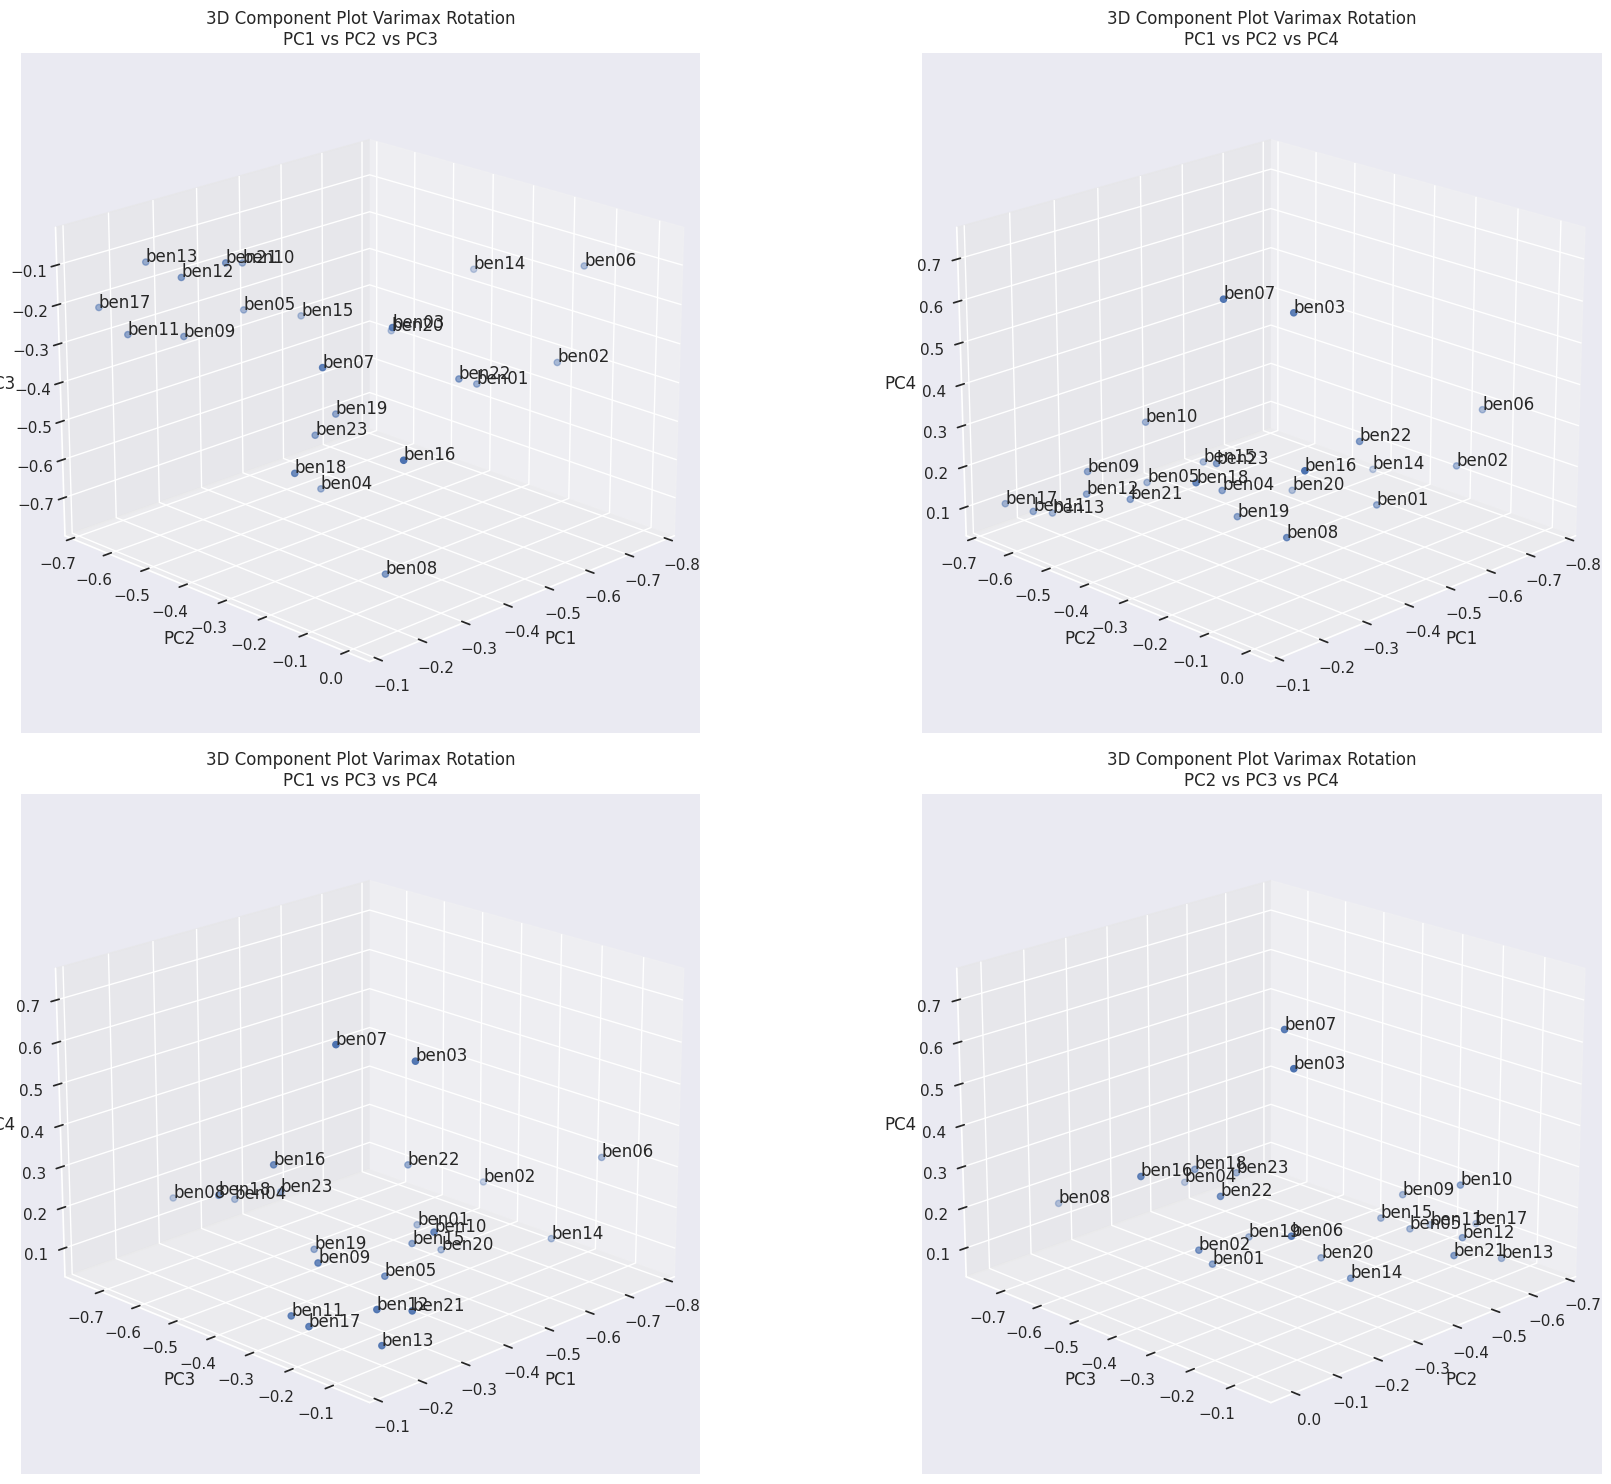

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# combinations for 3D plots
pc_combinations_3d = [
    ('PC1', 'PC2', 'PC3'),
    ('PC1', 'PC2', 'PC4'),
    ('PC1', 'PC3', 'PC4'),
    ('PC2', 'PC3', 'PC4')
]

#  subplots for all 3D combinations
fig = plt.figure(figsize=(20, 15))

for idx, (pc_x, pc_y, pc_z) in enumerate(pc_combinations_3d, 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')

    xs = df_varimax[pc_x]
    ys = df_varimax[pc_y]
    zs = df_varimax[pc_z]

    ax.scatter(xs, ys, zs)

    for i, varnames in enumerate(df_varimax.index):
        ax.text(xs[i], ys[i], zs[i], varnames)

    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_zlabel(pc_z)
    ax.set_title(f'3D Component Plot Varimax Rotation\n{pc_x} vs {pc_y} vs {pc_z}')

    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('3D Component plots varimax rotation.png')
plt.show()

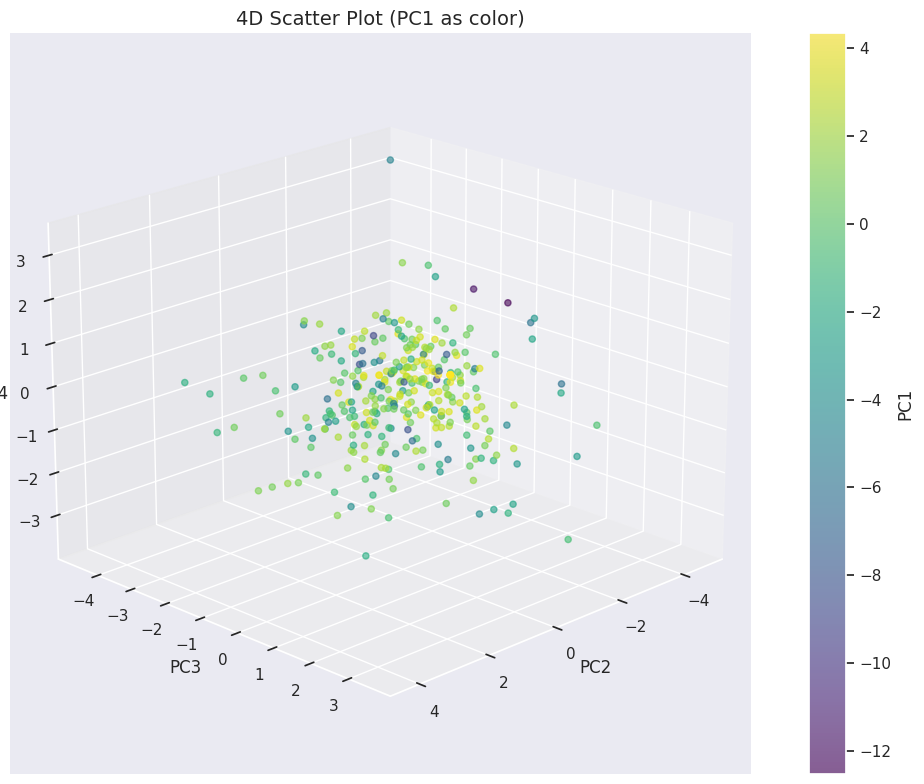

In [39]:
from mpl_toolkits.mplot3d import Axes3D


# Create a single 3D scatter plot with PC1 as color
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract principal components
xs = pca_df_4['PC2']  # x-axis
ys = pca_df_4['PC3']  # y-axis
zs = pca_df_4['PC4']  # z-axis
color_dimension = pca_df_4['PC1']  # color

# Create scatter plot
sc = ax.scatter(xs, ys, zs,
                c=color_dimension,
                cmap='viridis',
                marker='o',
                alpha=0.6)  # Added some transparency

# Add color bar
cbar = plt.colorbar(sc)
cbar.set_label('PC1', fontsize=12)

# Set labels and title
ax.set_xlabel('PC2', fontsize=12)
ax.set_ylabel('PC3', fontsize=12)
ax.set_zlabel('PC4', fontsize=12)
ax.set_title('4D Scatter Plot (PC1 as color)', fontsize=14)

# Set the viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

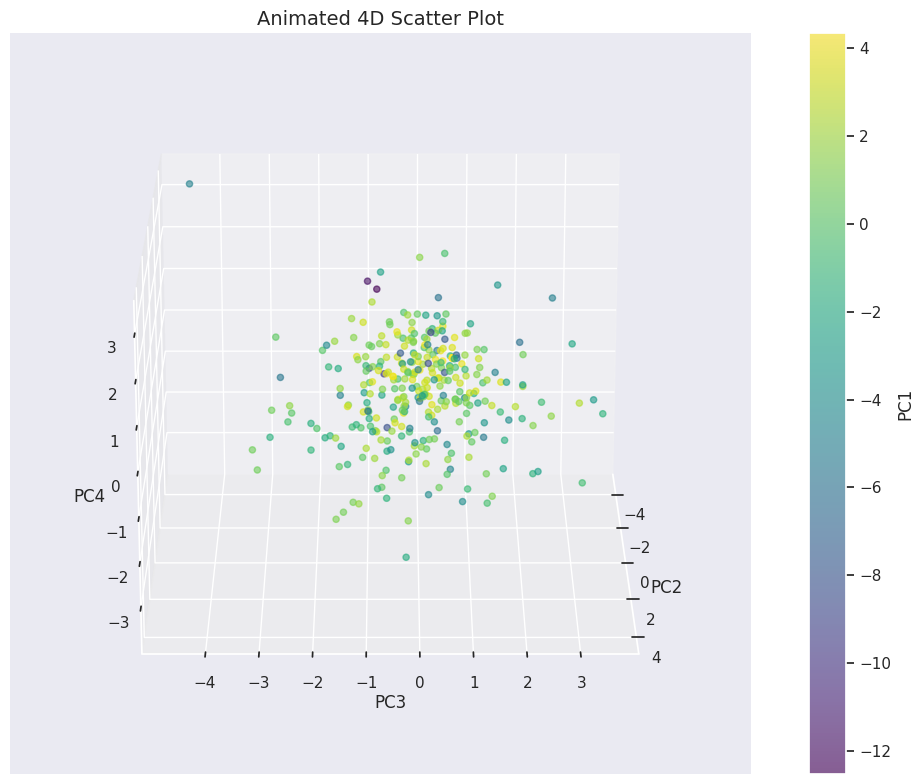

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
# Create figure and 3D axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract principal components
xs = pca_df_4['PC2']
ys = pca_df_4['PC3']
zs = pca_df_4['PC4']
colors = pca_df_4['PC1']

# Create scatter plot
scatter = ax.scatter(xs, ys, zs,
                    c=colors,
                    cmap='viridis',
                    alpha=0.6)  # Added transparency

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('PC1', fontsize=12)

# Set labels
ax.set_xlabel('PC2', fontsize=12)
ax.set_ylabel('PC3', fontsize=12)
ax.set_zlabel('PC4', fontsize=12)
ax.set_title('Animated 4D Scatter Plot', fontsize=14)

# Animation function
def rotate(frame):
    ax.view_init(elev=20, azim=frame)
    return fig,

# Create animation
# 180 frames, 2 degrees per frame = 360 degrees rotation
anim = animation.FuncAnimation(fig, rotate,
                             frames=np.linspace(0, 360, 180),
                             interval=50,  # 50ms between frames
                             blit=True)

# Uncomment the following line to save the animation
# anim.save('4d_rotation.gif', writer='pillow')

plt.tight_layout()
plt.show()

## Store Attributes Description

*   ben01: Customer services readily available
*   ben02: Knowledgeable personnel
*   ben03: Good selection of tapes and CDs
*   ben04: Clean, inviting appearance
*   ben05: Well laid out easy to locate things
*   ben06: Employees circulating to help
*   ben07: Good selection of household goods
*   ben08: Shopping for whole family
*   ben09: Wide selection of manufacturers
*   ben10: Advertised items in stock
*   ben11: Open convenient hours
*   ben12: Carrying sizes you need
*   ben13: Regular lower prices
*   ben14: Helpful store employees
*   ben15: Easy to complete transaction
*   ben16: Good selection of electronics
*   ben17: Stocking high quality goods
*   ben18: Good selection of holiday goods
*   ben19: Easy parking near store
*   ben20: Short wait at checkout
*   ben21: Store located nearby
*   ben22: Friendly environment
*   ben23: Roomy aisles





























## Labels

**PC1:Customer Service & Attention **

Its strongest loadings come from `ben06` (-0.772509, Employees circulating to help), `ben02` (-0.687659, Knowledgeable personnel),`ben14` (-0.690215, Helpful store employees) and `ben01` (-0.542404, Customer services readily available) . These variables focus on customer interaction and support, emphasizing the importance of personal attention and service quality to the overall customer experience.



**PC2:Shopping Value & Convenience **

Attributes related to the practical aspects of shopping. Strong loadings from `ben17` (-0.669674, Stocking high quality goods), `ben13` (-0.621712, Regular lower prices) and `ben11` (-0.590791, Open convenient hours) indicate this component represents the value customers get for their money and how easily they can shop, combining both economic and time-saving benefits.


**PC3:Store Navigation & Layout **

The physical shopping experience. With high loadings from `ben08` (-0.749798, Shopping for whole family), `ben04` (-0.625623, Clean, inviting appearance), and `ben23` (-0.472017, Roomy aisles), this component reflects how easily customers can move through and use the store space, emphasizing the importance of a comfortable shopping environment.



**PC4:Product Variety, **

Strong loadings from `ben07` (0.727055, Good selection of household goods), `ben03` (0.678913, Good selection of tapes and CDs), and `ben16` (0.401372, Good selection of electronics). This component clearly represents the diversity of products available to customers, highlighting the importance of having a wide range of merchandise options.